# CS 316 : Introduction to Deep Learning - Fall 2023
## Lab 04 : Linear Regression
### Dr. Abdul Samad

# Instructions
1. Please rename your notebook as *Lab_4_aa1234.ipynb* before the final submission. Notebooks which do not follow appropriate naming convention will not be graded.

2. Filling out the feedback form on Canvas is mandatory. Failure to do so will result in you losing 10% of your grade for this lab.

3. You have to submit this lab during the lab timings. You are allowed to submit till 11:59 PM on the day of your lab with a 30% penalty. No submissions will be accepted afterwards.

4. Please submit your own work. If you have any questions, please feel free to reach out to the course instructor or RA.

## Task Overview


Create a linear regression model using the Boston Housing Dataset to find the set of equations to predict the price of a house. This lab has been divided into small subtasks to make it easier to follow.

## Setup

In [75]:
# DO NOT EDIT
# Importing the essentials
%matplotlib inline
from IPython import display
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import os
import random
import urllib.request
import pandas as pd
np.random.seed(42)

## [10 Points] Task 01 - Download Boston Housing Dataset

A suitable dataset is required in order to obtain a linear regression model with reasonable accuracy. There are numerous datasets available, and many of them can be found online. You can also download the dataset manually, but scripting its retrieval is more convenient and may save time.
We'll use the urllib.request package to download the dataset.

**Your task is to download the Boston Housing Dataset by completing the function `get_boston_housing_dataset`. using the `urlib.request.urlretrive(url,filename)` method.**
\
**Link to Dataset**: [https://raw.githubusercontent.com/selva86/datasets/master/BostonHousing.csv](https://raw.githubusercontent.com/selva86/datasets/master/BostonHousing.csv)

In [76]:
# TODO: Complete get_boston_housing_dataset
def get_boston_housing_dataset(filename):
    """
    Download the boston housing dataset.
    If the file already exists, don't download the data again.
    Add appropriate error handling as well.

    Args:
        filename (string): The path where you want to save the file.
    Return:
        bool : True, if you successfully downloaded the data. False,  if the file already exists.
    """
    # Write your code here.
    if not os.path.exists(filename):
      urllib.request.urlretrieve('https://raw.githubusercontent.com/selva86/datasets/master/BostonHousing.csv',filename)
      return True
    return False




In [77]:
# DO NOT EDIT
# TEST CODE FOR CHECKING THE FUNCTION.
if not os.path.isdir("datasets"):
  os.mkdir("datasets")
BostonHousingCSV = os.path.join("datasets", "BostonHousing.csv")
if os.path.exists(BostonHousingCSV):
  assert get_boston_housing_dataset(BostonHousingCSV) == False
else:
  assert get_boston_housing_dataset(BostonHousingCSV) == True

## Exploratory Data Analysis

After downloading the csv file, let's observe the data and try to understand what it means. **The explanation for each column can be found at the end of the notebook in the section titled Explanations.**

In [78]:
# DO NOT EDIT
# Load the dataset
BostonHousingDataset = pd.read_csv(BostonHousingCSV)
# View the top rows of the dataset
BostonHousingDataset.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


Expected output is as follows:

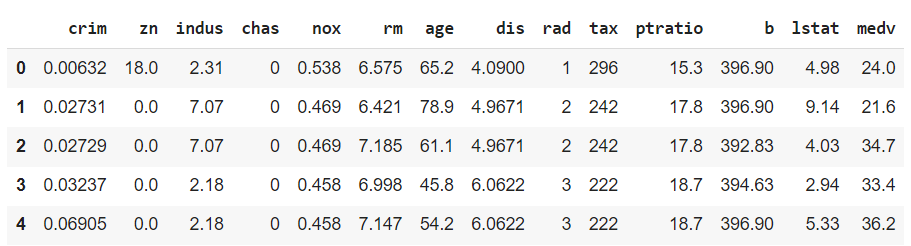

There is a lot of data. Most of the variables are unlikely to have a significant impact on the price. To avoid dealing with irrelevant columns, let us first determine which variables have a strong correlation with median price.

<ipython-input-79-7a054b480281>:3: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


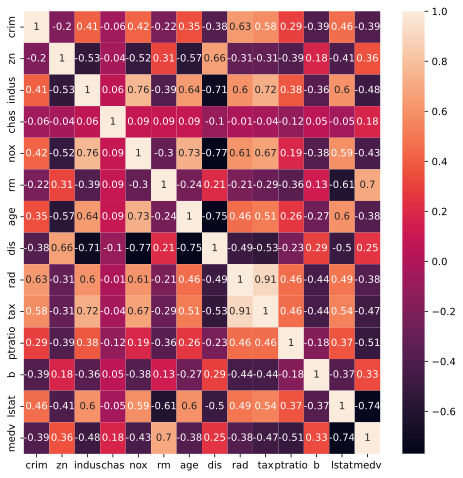

In [79]:
# DO NOT EDIT
%matplotlib inline
display.set_matplotlib_formats('svg')
plt.figure(figsize=(8,8))
correlation_matrix = BostonHousingDataset.corr().round(2)
sns.heatmap(data=correlation_matrix, annot=True)
plt.show()

Expected output is as follows:

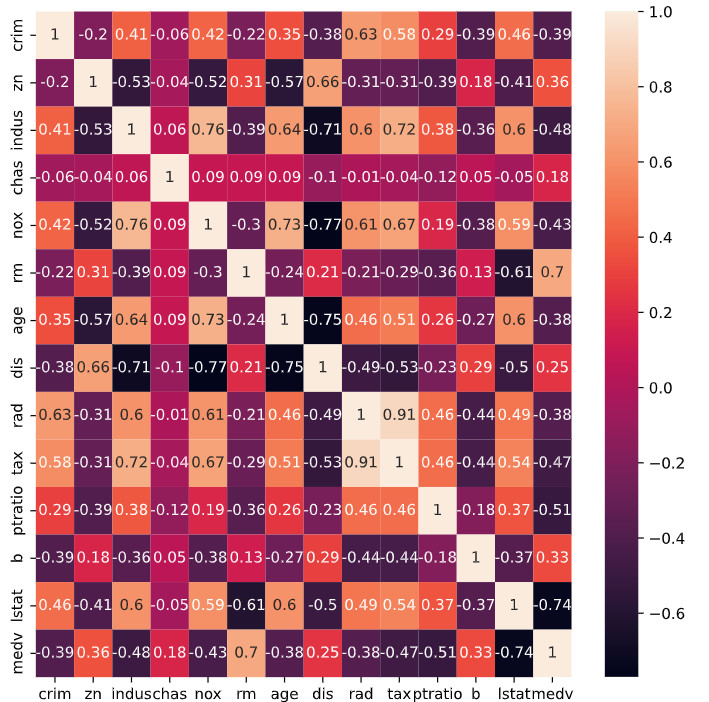

According to the heatmap, the two most important factors influencing price are **`lstat`** (Percentage of lower status of the population) and **`rm`** (Average number of rooms per dwelling). Consequently, we will be keep only these two columns. We can't add biases because we're only using matrices to find weights for each column. **As a result, we can add another column with a constant value of 1 that will serve as the bias.**

In [80]:
# DO NOT EDIT
# Extract only the relevant columns. X: Input, Y: Output
# iloc specifies the position of the column we want to select. :, part means all rows. ,-1 means last column
output = BostonHousingDataset.iloc[:,-1] # we can also do BostonHousingDataset['medv']
Y = np.array(output.values).reshape(-1,1)
X = np.array(BostonHousingDataset[['lstat','rm']].values)
print(Y.shape,X.shape)

(506, 1) (506, 2)


The expected output is as follows:


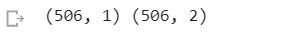

In [81]:
# DO NOT EDIT
ones = np.ones(shape=(len(X),1))
X_with_bias = np.concatenate((X,ones),axis=1)
print(X_with_bias.shape)

(506, 3)


The expected output is as follows:

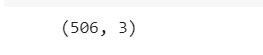

## [10 Points] Task 02 - Train Test Split

To determine whether regression is effective, we can split our data into a training and test set and compare performance. Before splitting data, make sure to shuffle it because data is sometimes arranged in a specific order, such as all low-end houses first. If the data is not properly shuffled, it may fail to learn patterns. So, to avoid bias in your training data, shuffle it before splitting.








**Your task is to split the dataset into training and test dataset by completing the function `train_test_split(inputs,outputs,test_size,seed)`**

**Important note on seed**: Reproducability is extremely important. Sometimes, you might find a good seed for a split. When dealing with random shuffling, you will get different results everytime you run. You can set a global seed by using `np.random.seed(42)` however that sets the global seed. It is useful over here to not change the global seed here, since if you want to reproduce the same result, you will have to run the entire code again. The solution to this problem is that you create a generator with a specific seed and use that for generation. [You can find more about setting seeds here](https://builtin.com/data-science/numpy-random-seed)

In [82]:
# TODO: Complete train_test_split
def train_test_split(inputs,outputs,test_size,seed = 0):
    """
    Splits the data into training and test sets.
    Return 4 numpy arrays. X_train, X_test, Y_train, Y_test
    where training data is test_size proportion of data provided.

    Args:
        inputs [np.array] : numpy array of input data
        outputs [np.array]: numpy array of output labels
        test_size [float]: proportion of data to be used as test data. e.g. 0.2 means 20% of data is used for test data.
        seed [int]: A seed to create random number generator. (For reproducability)
    """
    rng = np.random.default_rng(seed)
    assert(len(inputs) == len(outputs))
    assert(test_size <= 1.0)
    assert(test_size >= 0.0)
    num_samples = len(inputs)
    num_train = int(num_samples * (1.0 - test_size))
    # Write your code here
    # Create index using np.arange
    index = np.arange(num_samples)

    # Shuffle the index using rng.shuffle
    rng.shuffle(index)


    # Split the index into train, test
    train = index[:num_train:]
    test = index[num_train:]
    X_train = inputs[train]
    X_test = inputs[test]
    Y_train = outputs[train]
    Y_test = outputs[test]


    # Split the index into train, test



    return X_train, X_test, Y_train, Y_test

In [83]:
# DO NOT EDIT
# TEST CODE FOR CHECKING THE FUNCTION.
x_input = np.array([1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0])
y_output = np.array([3,4,5,6,7,8,9,10,11,12])
seed = 0
split = 0.5
x_train,x_test,y_train,y_test = train_test_split(x_input,y_output,split,seed)
print(f'x_train: {x_train}, x_test: {x_test}, y_train: {y_train}, y_test: {y_test}')
assert np.allclose(x_train,np.array([5.0,7.0,3.0,8.0,4.0]))
assert np.allclose(x_test,np.array([6.0,10.0,1.0,9.0,2.0]))
assert np.allclose(y_train,np.array([ 7,  9,  5, 10,  6]))
assert np.allclose(y_test,np.array([8,12,3,11,4]))

x_train: [5. 7. 3. 8. 4.], x_test: [ 6. 10.  1.  9.  2.], y_train: [ 7  9  5 10  6], y_test: [ 8 12  3 11  4]


The expected output is as follows:

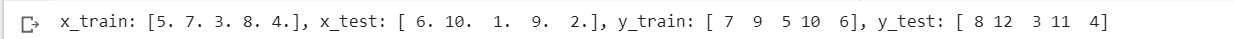

## [10 Points] Task 03 - Analytic Solution



Linear regression happens to be an unusually simple optimization problem.
Unlike most other models that we will encounter,
linear regression can be solved analytically by applying a simple formula.
To start, we can subsume the bias $b$ into the parameter $\mathbf{w}$
by appending a column to the design matrix consisting of all ones.
Then our prediction problem is to minimize $\|\mathbf{y} - \mathbf{X}\mathbf{w}\|^2$.
There is just one critical point on the loss surface
and it corresponds to the minimum of the loss over the entire domain.
Taking the derivative of the loss with respect to $\mathbf{w}$
and setting it equal to zero yields the analytic (closed-form) solution:

$$\mathbf{w}^* = (\mathbf X^\top \mathbf X)^{-1}\mathbf X^\top \mathbf{y}.$$

While simple problems like linear regression
may admit analytic solutions,
you should not get used to such good fortune.
Although analytic solutions allow for nice mathematical analysis,
the requirement of an analytic solution is so restrictive
that it would exclude all of deep learning.

**In this Task, you are required to compute the analytic solution by completing the function `analytical_solution`**

In [84]:
#TODO: Complete analytical solution
def analytical_solution(X,y):
    """
    Returns the analytical solution to the dataset
    Args:
        X [np.array] : Inputs
        y [np.array]: Outputs
    """
    # Write your code here
    a = X.T @ X
    inva = np.linalg.inv(np.matrix(a))
    b = X.T @ y
    final_ans = inva @ b
    return final_ans



In [85]:
# DO NOT EDIT
# TEST CODE FOR CHECKING THE FUNCTION.
w_test = analytical_solution(X_with_bias,Y)
print(f'w[0]: {w_test[0][0]}, w[1]: {w_test[1][0]}, w[2]: {w_test[2][0]}, w_test.shape {w_test.shape}')
assert np.allclose(w_test,np.array([[-0.64235833],[ 5.09478798],[-1.35827281]]))

w[0]: [[-0.64235833]], w[1]: [[5.09478798]], w[2]: [[-1.35827281]], w_test.shape (3, 1)


## [10 Points] Task 04 - Linear Regression Model



Before we perform linear regression, we must define our model, relating its inputs and parameters to its outputs. Recall that to calculate the output of the linear model, we simply take the matrix-vector dot product of the input features $\mathbf{X}$ and the model weights $\mathbf{w}$, and add the offset $b$ to each example.



$$ \mathbf{Xw}+b$$

$$w\in \mathbb{R}^{n \times 1},\space \mathbf{X}\in \mathbb{R}^{m \times n}, \space b\in \mathbb{R}^{1}$$

**In this task you are required to initialse the model weights and bias by implementing the function `initialise_model`.**

In [86]:
# TODO: Complete initialise_model
def initialise_model(n):
    """
    Returns the model weights w, a vector of dimensions n x 1 initialsed with zeros and
    bias b, a scalar initialised with the value 0
    Args:
        n [int] : Number of features
    """
    # Write your code here.
    w = np.zeros((n,1))
    b = np.zeros(1)



    return w,b


In [87]:
# DO NOT EDIT
# TEST CODE FOR CHECKING THE FUNCTION.
w_test,b_test = initialise_model(5)
print(f'w: {w_test}, w.shape: {w_test.shape}, b: {b_test}, b.shape {b_test.shape}')
assert np.allclose(w_test,np.array([[0.],[0.],[0.],[0.],[0.]]))
assert np.allclose(b_test,np.array([0.]))

w: [[0.]
 [0.]
 [0.]
 [0.]
 [0.]], w.shape: (5, 1), b: [0.], b.shape (1,)


The expected output:

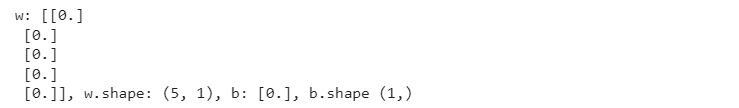

## [10 Points] Task 05 - Linear Output



**In this task, given model weights, bias, and input values, compute the linear output by implementing the function `forward`**

In [88]:
#TODO: Complete forward
def forward(X,w,b):
    """
    Returns the linear output of the model
    Args:
        X [np.array]: Input
        w [np.array]: Model Weights
        b [np.scalar]: Model Bias
    """
    # Write your code here

    dot_product = np.dot(X,w)
    sum = dot_product + b
    return sum


In [89]:
# DO NOT EDIT
# TEST CODE FOR CHECKING THE FUNCTION.
rng = np.random.RandomState(42)
x_test = rng.uniform(size=(2,2))
w_test = np.zeros((2,1))
b_test = np.zeros(1)
split = 0.5
output_test = forward(x_test,w_test,b_test)
print(f'x: {x_test} , w: {w_test}, b: {b_test}, xw+b: {output_test}, output.shape {output_test.shape}')
assert np.array_equal(output_test,np.array([[0.],[0.]]))

x: [[0.37454012 0.95071431]
 [0.73199394 0.59865848]] , w: [[0.]
 [0.]], b: [0.], xw+b: [[0.]
 [0.]], output.shape (2, 1)


## [10 Points] Task 06 - Evaluation

Mean Squared error is defined as

$$\text{MSE} = \dfrac{1}{n}\sum\limits_{i=1}^{n}(y_i-\hat{y}_i)^2$$

where $y_i$ is your actual value and $\hat{y}_i$ is the predicted value.

**In this task you are required to compute the mean squared error by implementing the function `mean_squared_error`.**


In [90]:
#TODO: Complete mean_squared_error
def mean_squared_error(y_actual,y_prediction):
    """
    Returns mean squared error using prediction and actual data
    Args:
        y_actual [np.array]     : Actual output vector
        y_prediction [np.array] : Predicted output vector
    """
    # Write your code here
    a = np.mean((y_actual - y_prediction)**2)


    return a


In [91]:
# DO NOT EDIT
# TEST CODE FOR CHECKING THE FUNCTION.
y_act = np.ones(5)
y_pre = np.arange(5)
y_mse = mean_squared_error(y_act,y_pre)
print(f'y = {y_act}, y_hat = {y_pre}, mse= {y_mse}')
assert y_mse == 3.0

y = [1. 1. 1. 1. 1.], y_hat = [0 1 2 3 4], mse= 3.0


The expected output is as follows:

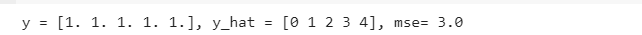

## [20 Points] Task 07 - Gradient Descent



$$L(\mathbf{w}, b) =\frac{1}{n}\sum_{i=1}^n l^{(i)}(\mathbf{w}, b) =\frac{1}{n} \sum_{i=1}^n \frac{1}{2}\left(\mathbf{w}^\top \mathbf{x}^{(i)} + b - y^{(i)}\right)^2$$

$$ \frac{\partial}{\partial \textbf{w}}L(\mathbf{w}, b)=  \frac{1}{n}\sum_{i=1}^n \mathbf{x}^{(i)} \left(\mathbf{w}^\top \mathbf{x}^{(i)} + b - y^{(i)}\right) =  \frac{1}{n} \space \mathbf{X}^T(\mathbf{Xw}+b-\mathbf{y})$$

$$ \frac{\partial}{\partial \textbf{w}}L(\mathbf{w}, b) = \frac{1}{n} \space \mathbf{X}^T(\mathbf{Xw}+b-\mathbf{y})\in \mathbb{R}^{2
\times 1}$$

$$ \frac{\partial}{\partial b}L(\mathbf{w}, b)=  \frac{1}{n}\sum_{i=1}^n  \left(\mathbf{w}^\top \mathbf{x}^{(i)} + b - y^{(i)}\right) =  \frac{1}{n}\sum_{i=1}^n  \left(\hat y^{(i)}- y^{(i)}\right)$$

**In this task you have to compute the gradient of the model weight and bias with respect to the loss function by implementing the function `gradient_descent`**

In [92]:
#TODO: Complete mean_squared_error
def gradient_descent(X,y,w,b,n):
    """
    Returns the gradient of model weights and bias with respect to the loss function
    Args:
        X [np.array]: Inputs
        y [np.array]: Outputs
        w [np.array]: Model Weights
        b [np.scalar]: Model Bias
        n [np.scalar]: Number of examples
    """
    # Write your code here
    sum = forward(X,w,b)
    a = sum - y
    b = X.T @ a
    grad_w = 1/n * b
    grad_b = 1/n *np.sum(a)



    return grad_w,grad_b

In [93]:
# DO NOT EDIT
# TEST CODE FOR CHECKING THE FUNCTION.
rng = np.random.RandomState(42)
x_test = rng.uniform(size=(2,2))
y_test = np.ones((2,1))
w_test = np.zeros((2,1))
b_test = np.zeros(1)
n = 2
grad_w, grad_b = gradient_descent(x_test,y_test,w_test,b_test,n)
print(f'x: {x_test},y: {y_test}, w: {w_test}, b: {b_test}, grad_w: {grad_w}, grad_w.shape {grad_w.shape}, grad_b: {grad_b}, grad_b.shape {grad_b.shape}')
assert np.allclose(grad_w,np.array([[-0.55326703],[-0.7746864 ]]))
assert np.allclose(grad_b,-1.0)

x: [[0.37454012 0.95071431]
 [0.73199394 0.59865848]],y: [[1.]
 [1.]], w: [[0.]
 [0.]], b: [0.], grad_w: [[-0.55326703]
 [-0.7746864 ]], grad_w.shape (2, 1), grad_b: -1.0, grad_b.shape ()


The expected output is as follows:

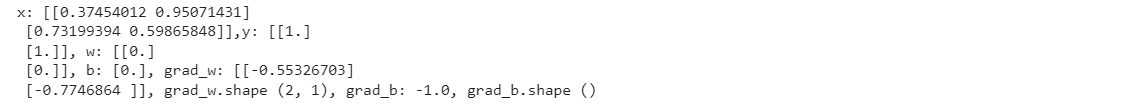

## [20 Points] Task 08 - Main Loop

Now that we have all of the parts in place, we are ready to **implement the main training loop.**

In each iteration, we will use the entire batch of training examples,
and pass them through our model to obtain a set of predictions.
After calculating the loss, we initiate the backwards pass through the network,
storing the gradients with respect to each parameter.
Finally, we will use the gradient descent optimization algorithm
to update the model parameters.

In summary, we will execute the following loop:

* Initialize parameters $(\mathbf{w}, b)$
* Repeat until done
    * Compute gradient $\mathbf{g} \leftarrow \partial_{(\mathbf{w},b)} \frac{1}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} l(\mathbf{x}^{(i)}, y^{(i)}, \mathbf{w}, b)$
    * Update parameters $(\mathbf{w}, b) \leftarrow (\mathbf{w}, b) - \eta \mathbf{g}$

In each *epoch*, we will iterate through the entire dataset once
passing through every example in the training dataset. The number of epochs `num_epochs` and the learning rate `lr` are both hyperparameters.





**In this task, you have to implement the linear regression by completing the function `main`**.

In [94]:
#TODO: Complete the function main
def main(X,y,num_epochs,lr):
    """
    Returns the final model weight and bias. Also, plots a graph of the num_epochs vs mean squared error.
    Args:
        X [np.array]: Inputs
        y [np.array]: Outputs
        num_epochs [int]: Number of epochs
        lr [floar]: Learning Rate
    """
    # Split the data into train & test dataset. Split should 0.2 and seed should be equal to 0
    X_train,X_test,Y_train,Y_test = train_test_split(X,y,0.2,0)
    # Initialize Weights
    w,b = initialise_model(X_train.shape[1])
    # Initialise empty L list
    L = []
    # Main Loop
    for epoch in range(num_epochs+1):
        # Write your code here
        # Compute the linear output using the training data
        Y_hat = forward(X_train,w,b)
        # Compute the loss on the training output
        loss = mean_squared_error(Y_hat,Y_train)
        # Store loss value in Python list
        L.append(loss)
        if epoch % 10 == 0:
          print(f'Epoch: {epoch}, loss: {loss}')
        # Compute grad_w, grad_b
        grad_w, grad_b = gradient_descent(X_train, Y_train, w , b,404)

        # Update w,b
        w = w -lr * grad_w
        b = b -lr * grad_b


    # Plot
    plt.plot([epoch for epoch in range(num_epochs+1)],L)
    plt.xlabel('Epochs')
    plt.ylabel('Mean Squared Loss')
    plt.title('Epochs vs Mean Squared Loss')
    plt.show()
    return w,b

Epoch: 0, loss: 601.9443811881189
Epoch: 10, loss: 113.36333742182049
Epoch: 20, loss: 58.07853701279157
Epoch: 30, loss: 40.70075503680248
Epoch: 40, loss: 35.23836126045895
Epoch: 50, loss: 33.52135506235616


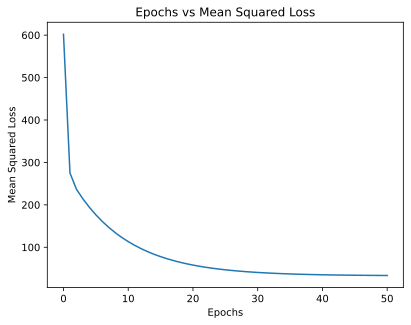

The final values are w: [[-0.56758392]
 [ 4.58957867]], b: [0.62701949]


In [95]:
# DO NOT EDIT
# TEST CODE FOR CHECKING THE FUNCTION.
w_act, b_act = main(X,Y,50,0.005)
print(f'The final values are w: {w_act}, b: {b_act}')
assert np.allclose (w_act,np.array([[-0.56758392],[ 4.58957867]]))
assert np.allclose (b_act,np.array([0.62701949]))

The expected output is as follows:

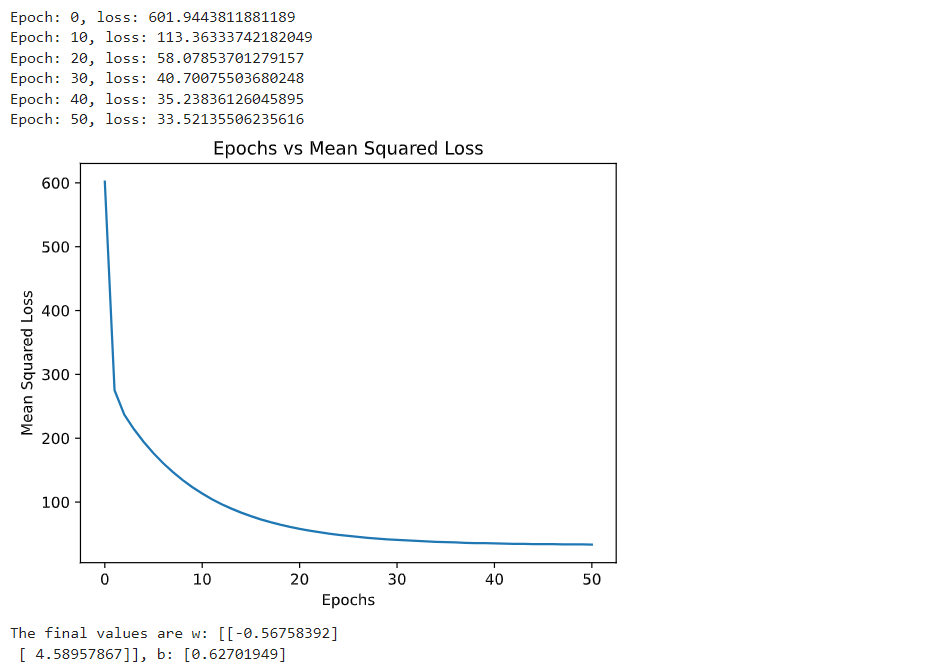

## Boston Housing Variables Meaning




`crim` : Per capita crime rate by town

`zn` : Proportion of residential land zoned for lots over 25,000 sq. ft

`indus` : Proportion of non-retail business acres per town

`chas` : Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)

`nox` : Nitric oxide concentration (parts per 10 million)

`rm` : Average number of rooms per dwelling

`age` : Proportion of owner-occupied units built prior to 1940

`dis` : Weighted distances to five Boston employment centers

`rad` : Index of accessibility to radial highways

`tax` : Full-value property tax rate per $10,000

`ptratio` : Pupil-teacher ratio by town

`b` : $1000(Bk — 0.63)^2$, where Bk is the proportion of [people of African American descent] by town

`lstat` : Percentage of lower status of the population

`medv` : Median value of owner-occupied homes in $1000s
